### Downloads

In [5]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

## Imports

In [6]:
import nltk
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import WordNetLemmatizer
from sklearn.tree import DecisionTreeClassifier
from nltk.corpus import wordnet
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Read file

In [8]:
CSV_PATH = os.path.join('website_classification.csv')
ws = pd.read_csv(CSV_PATH)

In [9]:
ws.head()

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


## Statistical Description

In [10]:
ws.shape

(1408, 4)

In [11]:
ws.drop(['Unnamed: 0'], axis =1, inplace = True)
ws.head()

,website_url,cleaned_website_text,Category
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


In [12]:
ws.isna().sum()

website_url             0
cleaned_website_text    0
Category                0
dtype: int64

In [13]:
ws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408 entries, 0 to 1407
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   website_url           1408 non-null   object
 1   cleaned_website_text  1408 non-null   object
 2   Category              1408 non-null   object
dtypes: object(3)
memory usage: 33.1+ KB


In [14]:
ws.shape

(1408, 3)

## Separating feature and target

In [15]:
X = ws['cleaned_website_text']
y = ws['Category']

In [16]:
y.unique()

array(['Travel', 'Social Networking and Messaging', 'News',
       'Streaming Services', 'Sports', 'Photography',
       'Law and Government', 'Health and Fitness', 'Games', 'E-Commerce',
       'Forums', 'Food', 'Education', 'Computers and Technology',
       'Business/Corporate', 'Adult'], dtype=object)

In [17]:
vc = y.value_counts()
vc

Education                          114
Business/Corporate                 109
Travel                             107
Streaming Services                 105
Sports                             104
E-Commerce                         102
Games                               98
News                                96
Health and Fitness                  96
Photography                         93
Computers and Technology            93
Food                                92
Law and Government                  84
Social Networking and Messaging     83
Forums                              16
Adult                               16
Name: Category, dtype: int64

In [18]:
X = pd.DataFrame(X)

In [19]:
X

,cleaned_website_text
0,official site good hotel accommodation big sav...
1,expedia hotel book sites like use vacation wor...
2,tripadvisor hotel book sites like previously d...
3,cheap flights search compare flights momondo f...
4,bot create free account create free account si...
...,...
1403,old nude women porn mature granny sex horny ol...
1404,bdsm cams bdsm chat bondage cams free bdsm vid...
1405,porno dvd online european porn dvd cheap adult...
1406,anal dream house anal dream house anal dream h...


## Class Description

In [20]:
vc_sorted = vc.index.tolist()
vc_sorted.sort()


In [21]:
c = ['green', 'magenta', 'grey','blue', 'orange']

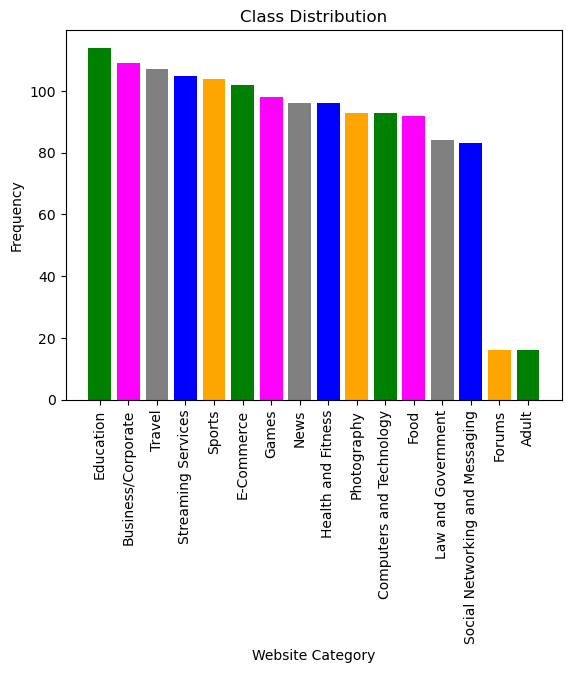

In [22]:
plt.bar(x = vc.index, height= vc.values, color = c)  
plt.xticks(rotation =90)
plt.title('Class Distribution')
plt.xlabel ('Website Category')
plt.ylabel ('Frequency')
plt.show()

## Text processing for features

In [23]:
X['cleaned_website_text']= X['cleaned_website_text'].str.replace(r'[^A-Za-z\s]', ' ', regex=True)

### Lemmatization

In [24]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    
    words = nltk.word_tokenize(text)
    
    lemmatized_words = []
    for word, tag in nltk.pos_tag(words):
        pos = tag[0].lower()  # Get the first character of the POS tag (e.g., 'n' for noun)
        pos = pos if pos in ['a', 'r', 'n', 'v'] else None  # Map POS tag to WordNet POS
        if not pos:
            lemma = word
        else:
            lemma = lemmatizer.lemmatize(word, pos=pos)
        lemmatized_words.append(lemma)
    
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

In [25]:
X['lemmatized_website_text'] = X['cleaned_website_text'].apply(lemmatize_text)

In [26]:
X['lemmatized_website_text']

0       official site good hotel accommodation big sav...
1       expedia hotel book site like use vacation work...
2       tripadvisor hotel book site like previously de...
3       cheap flight search compare flight momondo fin...
4       bot create free account create free account si...
                              ...                        
1403    old nude woman porn mature granny sex horny ol...
1404    bdsm cam bdsm chat bondage cam free bdsm video...
1405    porno dvd online european porn dvd cheap adult...
1406    anal dream house anal dream house anal dream h...
1407    world sex news daily sex news adult news eroti...
Name: lemmatized_website_text, Length: 1408, dtype: object

### Text Encoding

In [27]:
vectorizer = CountVectorizer()
text_counts = vectorizer.fit_transform(X['lemmatized_website_text'])

In [28]:
text_counts.shape

(1408, 53594)

In [29]:
columns = vectorizer.get_feature_names_out()

In [30]:
columns

array(['aa', 'aaa', 'aaaannnnnd', ..., 'zyt', 'zz', 'zzp'], dtype=object)

In [31]:
df_encoded = pd.DataFrame(text_counts.toarray(), columns=vectorizer.get_feature_names_out())

In [32]:
df_encoded

,aa,aaa,aaaannnnnd,aaaargh,aaacn,aaap,aab,aabaad,aac,aachen,...,zwillinger,zx,zygote,zykowej,zynixmedia,zynn,zypping,zyt,zz,zzp
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1405,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
word_counts = df_encoded.sum()

df_word_counts = pd.DataFrame({
    'word': word_counts.index, 
    'count': word_counts.values
})

In [34]:
df_word_counts.describe()

,count
count,53594.000000
mean,19.381964
std,101.287874
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,5332.000000


In [35]:
mean_word_count = df_word_counts['count'].mean()

In [36]:
selected_words = df_word_counts[df_word_counts['count'] < mean_word_count]['word']

In [37]:
selected_words

0                aa
1               aaa
2        aaaannnnnd
3           aaaargh
4             aaacn
            ...    
53589          zynn
53590       zypping
53591           zyt
53592            zz
53593           zzp
Name: word, Length: 47034, dtype: object

In [38]:
df_encoded.drop(columns=selected_words.values, inplace=True)

In [39]:
df_encoded.shape

(1408, 6560)

In [40]:
df_encoded.describe()

,aafp,aaron,ab,abandon,abc,abigail,ability,able,abroad,absence,...,zero,zimbabwe,zinc,zip,zodiac,zombie,zone,zoom,zoomcar,zucchini
count,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,...,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000
mean,0.029830,0.020597,0.026278,0.017045,0.098011,0.014205,0.065341,0.166193,0.041193,0.031250,...,0.044034,0.033381,0.022727,0.049716,0.037642,0.014205,0.085938,0.061080,0.019886,0.023438
std,1.119304,0.210598,0.216629,0.202316,1.484455,0.324016,0.359646,0.723801,0.412673,0.397777,...,0.368703,0.410792,0.440708,0.392285,0.545711,0.252515,0.654437,0.569759,0.746203,0.388376
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,42.000000,4.000000,4.000000,4.000000,41.000000,11.000000,7.000000,11.000000,9.000000,12.000000,...,10.000000,13.000000,15.000000,7.000000,16.000000,7.000000,12.000000,10.000000,28.000000,13.000000


In [41]:
X_lemma = df_encoded
X_lemma.head()

,aafp,aaron,ab,abandon,abc,abigail,ability,able,abroad,absence,...,zero,zimbabwe,zinc,zip,zodiac,zombie,zone,zoom,zoomcar,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Test train split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_lemma, y, test_size=0.2, random_state=21)

## Function to display results

In [43]:
def get_results(model, X, y, tt):
    y_pred= model.predict(X)
    print("\t"*2,"*"*8, f"RESULTS FOR {tt} SET",  "*"*8)
    print(classification_report(y, y_pred))
    print("\n")
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= vc_sorted )
    disp.plot()
    plt.xticks(rotation =90)
    plt.title(f"CONFUSION MATRIX FOR {tt} SET")
    plt.show()

## Use of Classifiers

### SVM

In [44]:
svm_clf = SVC( random_state=21)

In [45]:
svm_clf.fit(X_train, y_train)

SVC(random_state=21)

		 ******** RESULTS FOR TRAIN SET ********
                                 precision    recall  f1-score   support

                          Adult       1.00      0.17      0.29        12
             Business/Corporate       0.29      1.00      0.45        87
       Computers and Technology       0.96      0.57      0.71        76
                     E-Commerce       0.98      0.69      0.81        90
                      Education       0.97      0.76      0.85        88
                           Food       1.00      0.59      0.75        69
                         Forums       1.00      0.07      0.13        14
                          Games       1.00      0.76      0.86        78
             Health and Fitness       1.00      0.74      0.85        80
             Law and Government       1.00      0.69      0.81        67
                           News       0.98      0.86      0.91        69
                    Photography       1.00      0.57      0.72        74
Social 

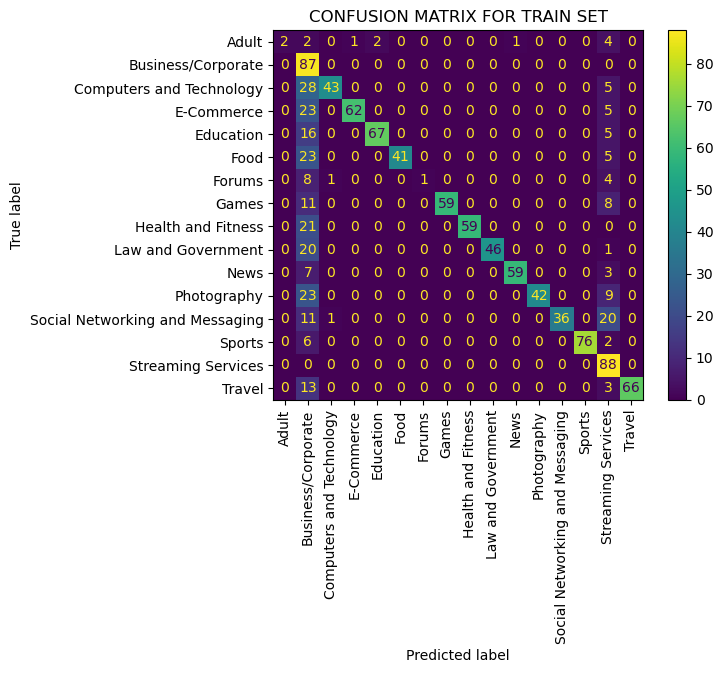

In [46]:
get_results(svm_clf, X_train, y_train, 'TRAIN')

		 ******** RESULTS FOR TEST SET ********
                                 precision    recall  f1-score   support

                          Adult       0.00      0.00      0.00         4
             Business/Corporate       0.25      1.00      0.40        22
       Computers and Technology       1.00      0.59      0.74        17
                     E-Commerce       1.00      0.25      0.40        12
                      Education       0.94      0.62      0.74        26
                           Food       1.00      0.43      0.61        23
                         Forums       0.00      0.00      0.00         2
                          Games       0.82      0.70      0.76        20
             Health and Fitness       0.88      0.44      0.58        16
             Law and Government       1.00      0.65      0.79        17
                           News       0.90      0.70      0.79        27
                    Photography       1.00      0.53      0.69        19
Social N

C:\Users\sabig\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sabig\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sabig\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


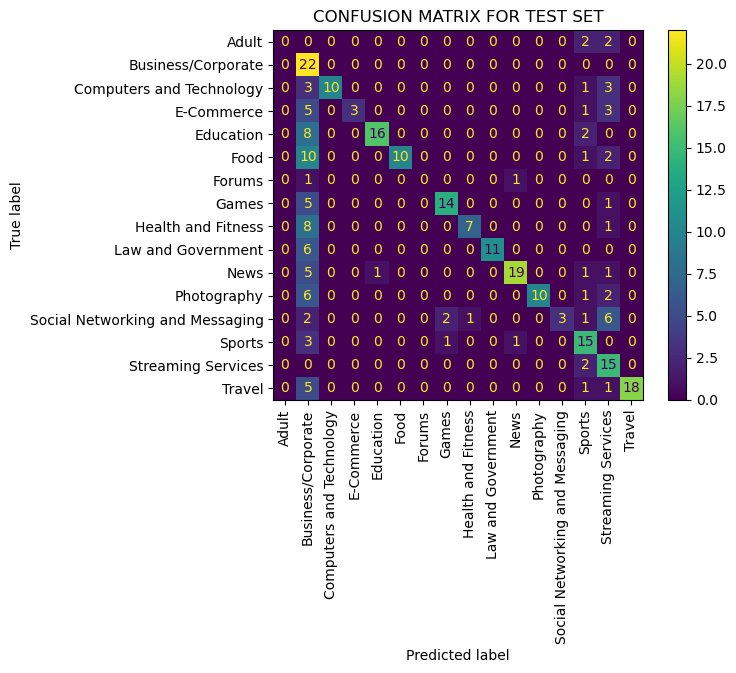

In [47]:
get_results(svm_clf, X_test, y_test, 'TEST')

### KNN 

In [48]:
knn_clf = KNeighborsClassifier(n_neighbors=3)

In [49]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

		 ******** RESULTS FOR TRAIN SET ********
                                 precision    recall  f1-score   support

                          Adult       1.00      1.00      1.00        12
             Business/Corporate       0.78      0.95      0.86        87
       Computers and Technology       0.71      0.88      0.79        76
                     E-Commerce       0.86      0.92      0.89        90
                      Education       0.94      0.85      0.89        88
                           Food       0.84      0.86      0.85        69
                         Forums       0.47      0.57      0.52        14
                          Games       0.89      0.94      0.91        78
             Health and Fitness       0.96      0.80      0.87        80
             Law and Government       0.95      0.88      0.91        67
                           News       0.87      0.87      0.87        69
                    Photography       0.90      0.95      0.92        74
Social 

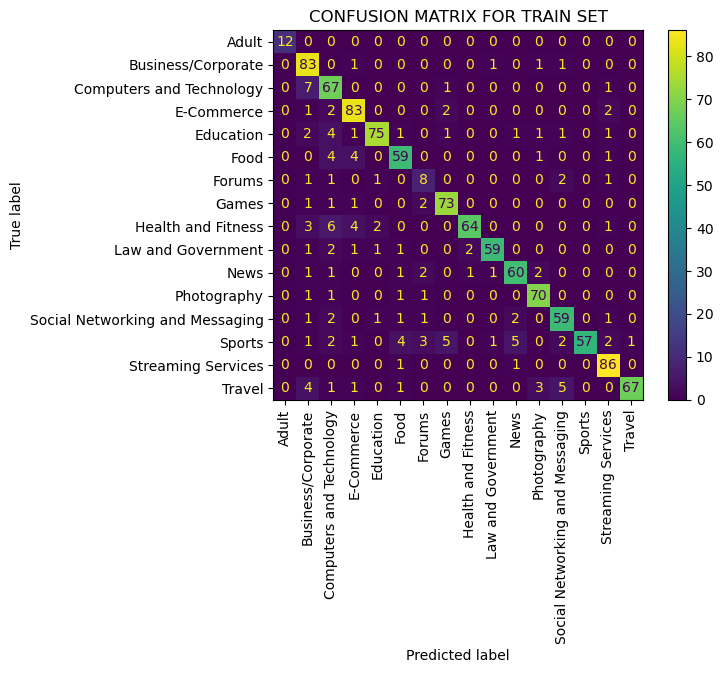

In [51]:
get_results(knn_clf, X_train, y_train, 'TRAIN')

		 ******** RESULTS FOR TEST SET ********
                                 precision    recall  f1-score   support

                          Adult       1.00      0.50      0.67         4
             Business/Corporate       0.45      0.41      0.43        22
       Computers and Technology       0.34      0.59      0.43        17
                     E-Commerce       0.50      0.58      0.54        12
                      Education       0.93      0.54      0.68        26
                           Food       0.37      0.65      0.47        23
                         Forums       0.25      0.50      0.33         2
                          Games       0.55      0.80      0.65        20
             Health and Fitness       1.00      0.50      0.67        16
             Law and Government       0.89      0.47      0.62        17
                           News       0.75      0.56      0.64        27
                    Photography       0.61      0.89      0.72        19
Social N

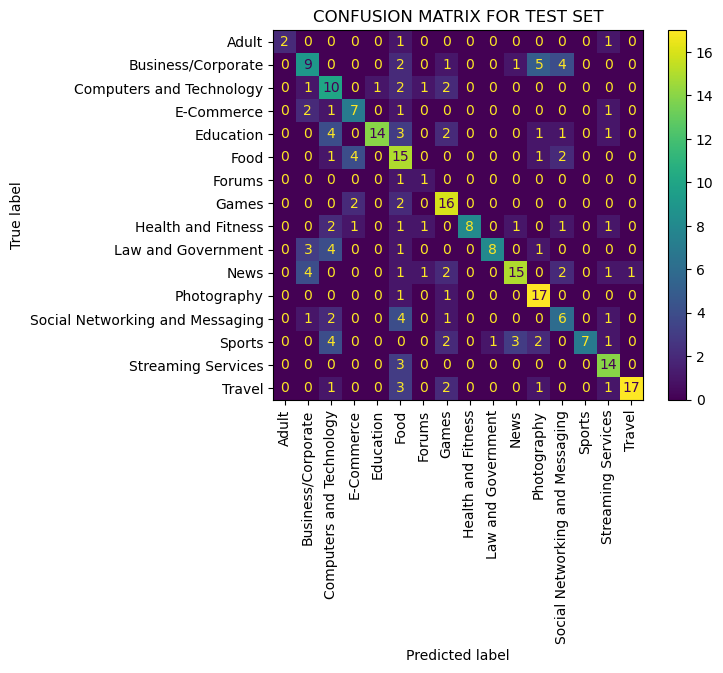

In [52]:
get_results(knn_clf, X_test, y_test, 'TEST')

### Decision Tree

In [54]:
dectre_clf = DecisionTreeClassifier(random_state=21)

In [55]:
dectre_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=21)

		 ******** RESULTS FOR TRAIN SET ********
                                 precision    recall  f1-score   support

                          Adult       1.00      1.00      1.00        12
             Business/Corporate       1.00      1.00      1.00        87
       Computers and Technology       1.00      1.00      1.00        76
                     E-Commerce       1.00      1.00      1.00        90
                      Education       1.00      1.00      1.00        88
                           Food       1.00      1.00      1.00        69
                         Forums       1.00      1.00      1.00        14
                          Games       1.00      1.00      1.00        78
             Health and Fitness       1.00      1.00      1.00        80
             Law and Government       1.00      1.00      1.00        67
                           News       1.00      1.00      1.00        69
                    Photography       1.00      1.00      1.00        74
Social 

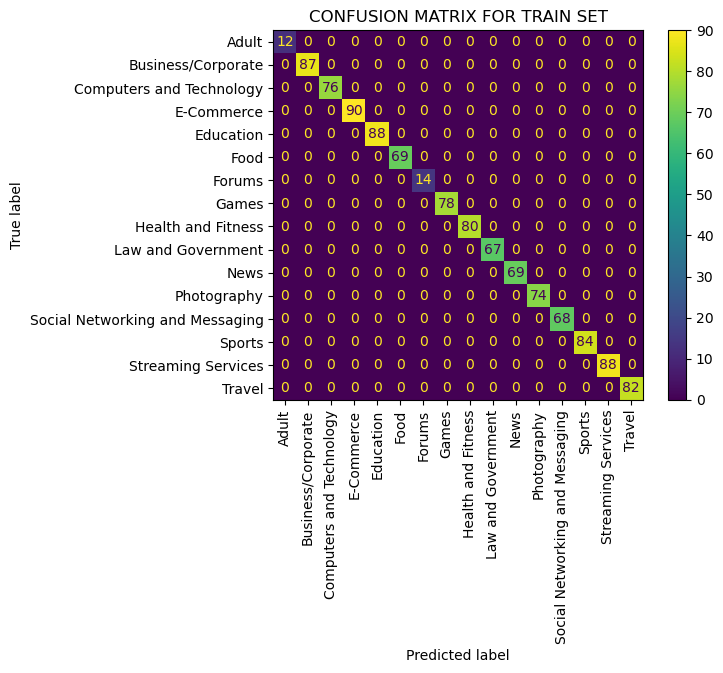

In [56]:
get_results(dectre_clf, X_train, y_train, 'TRAIN')

		 ******** RESULTS FOR TEST SET ********
                                 precision    recall  f1-score   support

                          Adult       1.00      0.25      0.40         4
             Business/Corporate       0.33      0.23      0.27        22
       Computers and Technology       0.44      0.65      0.52        17
                     E-Commerce       0.46      0.50      0.48        12
                      Education       0.60      0.58      0.59        26
                           Food       0.83      0.83      0.83        23
                         Forums       0.00      0.00      0.00         2
                          Games       0.73      0.80      0.76        20
             Health and Fitness       0.55      0.75      0.63        16
             Law and Government       0.69      0.65      0.67        17
                           News       0.59      0.48      0.53        27
                    Photography       0.89      0.84      0.86        19
Social N

C:\Users\sabig\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sabig\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sabig\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


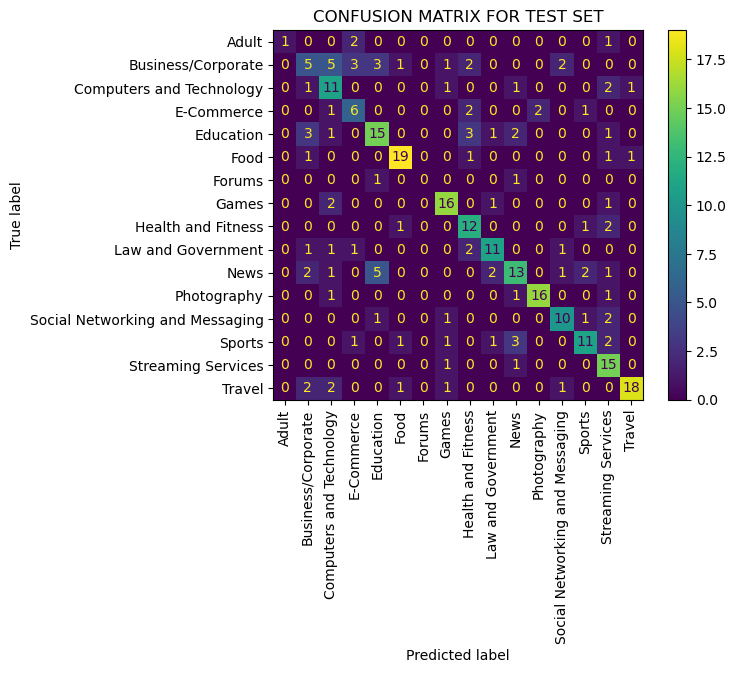

In [57]:
get_results(dectre_clf, X_test, y_test, 'TEST')

### Random Forest

In [59]:
ranfo_clf = RandomForestClassifier()

In [61]:
ranfo_clf.fit(X_train, y_train)

RandomForestClassifier()

		 ******** RESULTS FOR TRAIN SET ********
                                 precision    recall  f1-score   support

                          Adult       1.00      1.00      1.00        12
             Business/Corporate       1.00      1.00      1.00        87
       Computers and Technology       1.00      1.00      1.00        76
                     E-Commerce       1.00      1.00      1.00        90
                      Education       1.00      1.00      1.00        88
                           Food       1.00      1.00      1.00        69
                         Forums       1.00      1.00      1.00        14
                          Games       1.00      1.00      1.00        78
             Health and Fitness       1.00      1.00      1.00        80
             Law and Government       1.00      1.00      1.00        67
                           News       1.00      1.00      1.00        69
                    Photography       1.00      1.00      1.00        74
Social 

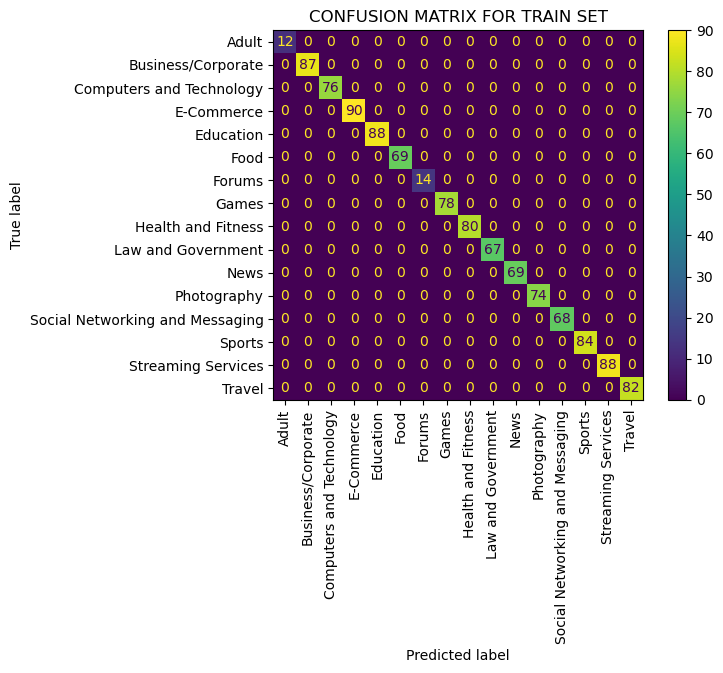

In [62]:
get_results(ranfo_clf, X_train, y_train, 'TRAIN')

		 ******** RESULTS FOR TEST SET ********
                                 precision    recall  f1-score   support

                          Adult       1.00      0.25      0.40         4
             Business/Corporate       0.85      0.77      0.81        22
       Computers and Technology       0.80      0.71      0.75        17
                     E-Commerce       0.69      0.92      0.79        12
                      Education       0.81      0.85      0.83        26
                           Food       0.95      0.87      0.91        23
                         Forums       0.00      0.00      0.00         2
                          Games       0.73      0.80      0.76        20
             Health and Fitness       0.76      0.81      0.79        16
             Law and Government       0.83      0.88      0.86        17
                           News       0.82      0.67      0.73        27
                    Photography       0.90      0.95      0.92        19
Social N

C:\Users\sabig\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sabig\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sabig\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


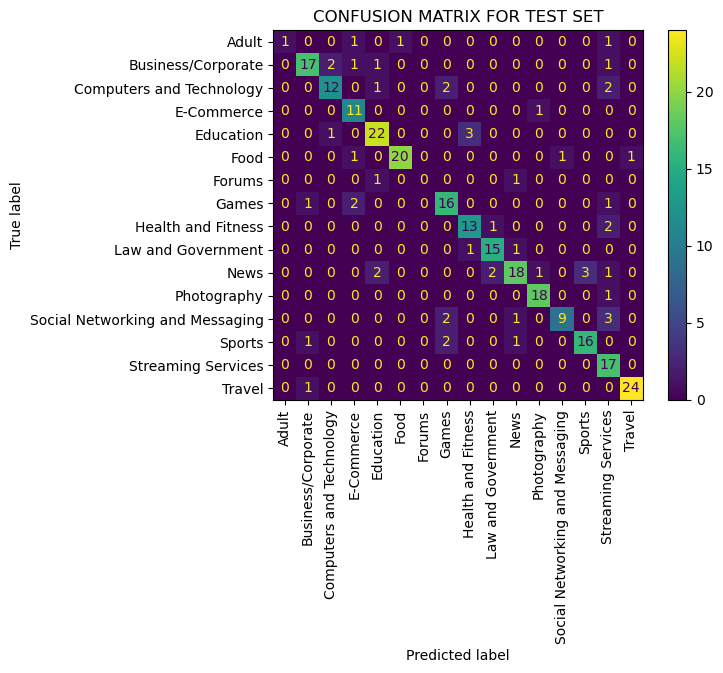

In [64]:
get_results(ranfo_clf, X_test, y_test, 'TEST')

### ADA Boost

In [74]:
adab_clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME",random_state = 21)

In [75]:
adab_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=21)

		 ******** RESULTS FOR TRAIN SET ********
                                 precision    recall  f1-score   support

                          Adult       1.00      0.33      0.50        12
             Business/Corporate       0.25      0.75      0.37        87
       Computers and Technology       0.44      0.51      0.47        76
                     E-Commerce       0.94      0.64      0.76        90
                      Education       0.60      0.58      0.59        88
                           Food       0.97      0.54      0.69        69
                         Forums       0.00      0.00      0.00        14
                          Games       0.66      0.77      0.71        78
             Health and Fitness       0.96      0.55      0.70        80
             Law and Government       0.84      0.72      0.77        67
                           News       0.85      0.81      0.83        69
                    Photography       0.94      0.80      0.86        74
Social 

C:\Users\sabig\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sabig\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sabig\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


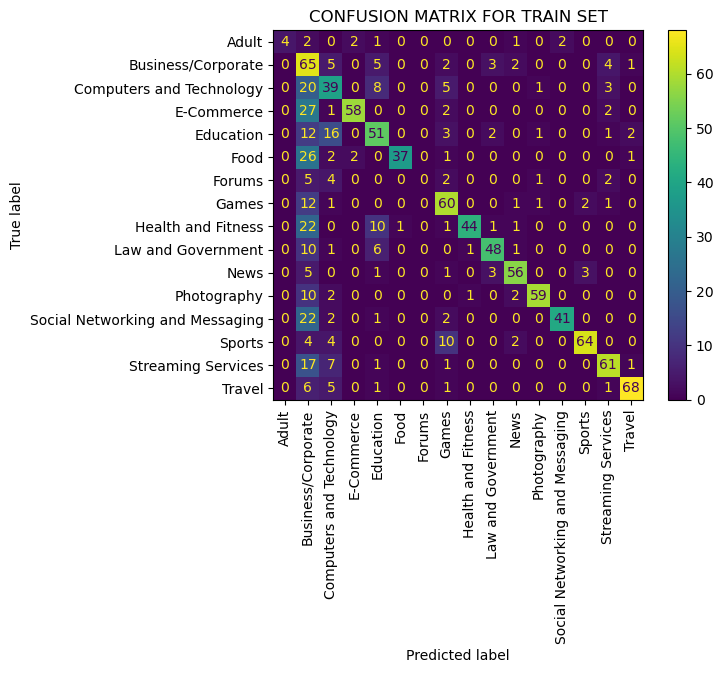

In [76]:
get_results(adab_clf, X_train, y_train, 'TRAIN')

		 ******** RESULTS FOR TEST SET ********
                                 precision    recall  f1-score   support

                          Adult       0.00      0.00      0.00         4
             Business/Corporate       0.15      0.59      0.24        22
       Computers and Technology       0.43      0.53      0.47        17
                     E-Commerce       0.86      0.50      0.63        12
                      Education       0.71      0.58      0.64        26
                           Food       1.00      0.52      0.69        23
                         Forums       0.00      0.00      0.00         2
                          Games       0.58      0.70      0.64        20
             Health and Fitness       0.89      0.50      0.64        16
             Law and Government       0.85      0.65      0.73        17
                           News       0.84      0.59      0.70        27
                    Photography       0.90      0.47      0.62        19
Social N

C:\Users\sabig\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sabig\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sabig\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


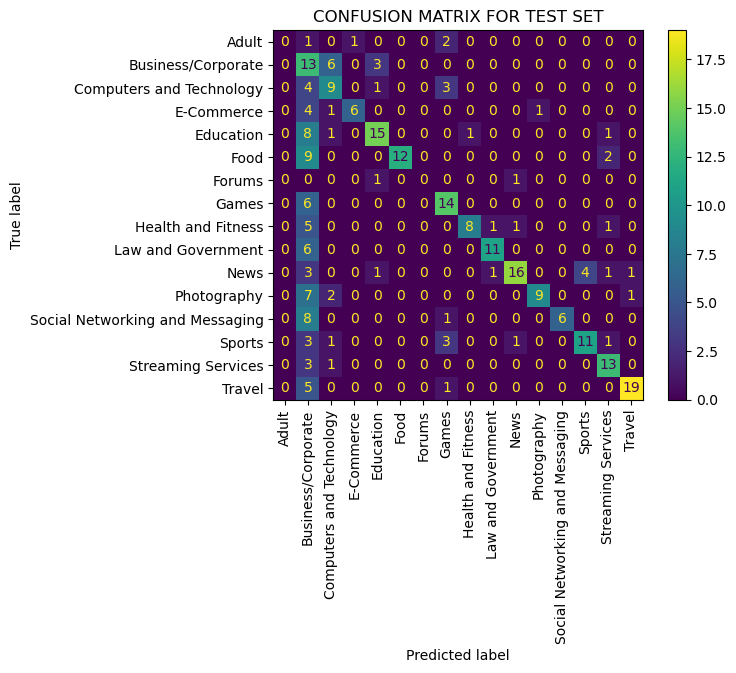

In [77]:
get_results(adab_clf, X_test, y_test, 'TEST')

### XGBoost